### Nombre: Elena Jaramillo Rosado

## Primer Clasificador TFM

Este primer clasificador toma los datos del dataset __dataset_translated.csv__ y predice a partir de las columnas 'bio' e 'interest' si el género ('gender') es Hombre (**Man**) o Mujer (**Woman**). El objetivo de este clasificador es el de obtener un dataset resultante en el que el número de registros donde gender = 'NotSpecified' es similar al número de registros donde gender = 'Woman' o 'Man' 

El procedimiento que se va a seguir es de self-training. Va a consistir de los siguientes pasos:

- Se entrena un modelo base (en este caso, se usará Regresión Logística) usando el conjunto de datos etiquetados disponible.

- El modelo entrenado se usa para predecir las etiquetas de los datos no etiquetados.

- Se seleccionan registros del conjunto no etiquetado cuyos resultados predichos tienen una alta confianza.

- Los registros seleccionados se agregan al conjunto de datos etiquetado.
    
- Se vuelve a entrenar el modelo con el conjunto etiquetado expandido. 

Este proceso se hará de forma iterativa hasta que se lleguen a la mitad de los datos etiquetados o no existan predicciones con la suficiente confianza.

In [7]:
from utils.Preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.utils import resample
from emoji import demojize
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
import re
import matplotlib.pyplot as plt

In [2]:
# Ruta al dataset
path_df = './datasets/dataset_translated.csv'

df = pd.read_csv(path_df, sep = ',', header = 0)
df.head(10)

,age,bio,job,school,anthem_title,anthem_artist,gender,descriptor_text,interest_text,total_photos,desition,longitud,latitud,hash_key,descriptor,interest,city_hashed
0,23.0,Do I want it or do I want techno?|The one with...,['NotSpecified'],NaN,Mood Swings (feat. Lil Tjay),Pop Smoke; Lil Tjay,NotSpecified,|Pisces|Better in person|Beer,NaN,15,2,-3.684574,40.415211,-3.388780e+17,"['Pisces', 'Better in person', 'Beer']",[],500a2b51765bf57441a2a5ba95621dcccc92722c51d321...
1,27.0,with something to do tomorrow.|,['NotSpecified'],NaN,NaN,NaN,NotSpecified,NaN,NaN,14,2,-3.684574,40.415211,6.305302e+18,[],[],4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
2,20.0,a few joints and a beer or are we going to a r...,['ketalal'],NaN,Visiones de la Muerte,Fertil Miseria,NotSpecified,|Scorpio|Pet-free|Smoker|Beer,|Coffee|Writer|Craft Beer|Wine|Extrovert,8,2,-3.684574,40.415211,-6.136008e+18,"['Scorpio', 'Pet-free', 'Smoker', 'Beer']","['Coffee', 'Writer', 'Craft Beer', 'Wine', 'Ex...",4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
3,22.0,nice but clumsy.|funny but stubborn.|clown but...,['NotSpecified'],NaN,NaN,NaN,NotSpecified,|Taurus|Beer,|Music|Camping|Travel|Grab a drink,8,2,-3.684574,40.415211,5.360212e+18,"['Taurus', 'Beer']","['Music', 'Camping', 'Travel', 'Grab a drink']",500a2b51765bf57441a2a5ba95621dcccc92722c51d321...
4,26.0,something different!,['NotSpecified'],Uem,NaN,NaN,NotSpecified,NaN,|Fashion|Festivals|Travel|Esports,1,2,-3.684574,40.415211,-4.665239e+17,[],"['Fashion', 'Festivals', 'Travel', 'Esports']",4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
5,21.0,||:woman_police_officer_light_skin_tone::blue_...,['NotSpecified'],NaN,NaN,NaN,NotSpecified,|Socially active|Virgo|Wine|Dog|Smoker,|Wine|Foodie|Dog lover,15,2,-3.684574,40.415211,5.196545e+18,"['Socially active', 'Virgo', 'Wine', 'Dog', 'S...","['Wine', 'Foodie', 'Dog lover']",4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
6,18.0,"If you are a fascist, go back to where you cam...",['NotSpecified'],NaN,My Own Summer (Shove It),Deftones,NotSpecified,|Aquarius|B time texter|Occasionally|All the d...,|Festivals|Tattoos|Spirituality|Activism|Music,11,2,-3.684574,40.415211,3.261688e+18,"['Aquarius', 'B time texter', 'Occasionally', ...","['Festivals', 'Tattoos', 'Spirituality', 'Acti...",500a2b51765bf57441a2a5ba95621dcccc92722c51d321...
7,18.0,::anatomical_heart:|:Venezuela:,['NotSpecified'],NaN,NaN,NaN,Woman,|Virgo|Gym rat,|Festivals|Instagram|Travel|World Traveler|Sho...,5,2,-3.684574,40.415211,4.220185e+18,"['Virgo', 'Gym rat']","['Festivals', 'Instagram', 'Travel', 'World Tr...",500a2b51765bf57441a2a5ba95621dcccc92722c51d321...
8,34.0,trans girl :transgender_flag: |if you like it;...,['NotSpecified'],NaN,Luces de Neón,Varry Brava,NotSpecified,|Capricorn|Better in person|Occasionally|Non-s...,|Reading|Travel|Movies|Disney|Netflix,8,2,-3.684574,40.415211,7.696506e+18,"['Capricorn', 'Better in person', 'Occasionall...","['Reading', 'Travel', 'Movies', 'Disney', 'Net...",4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
9,23.0,"fun girl; sincere, passionate about music | co...",['cocinera at restaurante'],Universidad Autónoma de Madrid,The Nhts,Avicii,NotSpecified,|Aries|B time texter|Occasionally|Non-smoker|S...,|Foodie|Photography|Musician|Tattoos|Cooking,11,2,-3.684574,40.415211,-7.564959e+18,"['Aries', 'B time texter', 'Occasionally', 'No...","['Foodie', 'Photography', 'Musician', 'Tattoos...",500a2b51765bf57441a2a5ba95621dcccc92722c51d321...


In [3]:
# Preprocessing() es una clase que he creado para englobar acciones de preprocesamiento.

preprocessing = Preprocessing()

df['bio'] = df['bio'].apply(preprocessing.lowercase).apply(preprocessing.remove_vertical_bars).apply(preprocessing.remove_numbers)
df['interest_text'] = df['interest_text'].apply(preprocessing.lowercase).apply(preprocessing.remove_vertical_bars).apply(preprocessing.remove_numbers)
df['gender'] = df['gender'].str.strip("[]'")

In [4]:
a = preprocessing.remove_numbers('holaaa!!??:.,')
print(a)

holaaa


In [5]:
df['bio']

0       do i want it or do i want techno the one with ...
1                          with something to do tomorrow 
2       a few joints and a beer or are we going to a r...
3       nice but clumsy funny but stubborn clown but g...
4                                     something different
                              ...                        
3951    i like anime movies video games food and being...
3952                           sportsgardeningmotorcycles
3953    quiet guy who does things smilingfacewithhalo ...
3954    motor sportsexpositionsdrawingroad tripscar ra...
3955    who stops for a bike ridepartyingfacebicycle  ...
Name: bio, Length: 3956, dtype: object

In [6]:
df['gender'].value_counts()

gender
NotSpecified            3054
Woman                    445
Man                      442
Mujer trans                3
Género no binario          1
idea                       1
Pareja                     1
Trans man                  1
fluid                      1
ゲイ                         1
Transgender Woman          1
Trans woman                1
Bisexual                   1
Trans                      1
Cupcake de frambuesa       1
trans                      1
Name: count, dtype: int64

Vemos que las clases mayoritarias del atributo 'gender' son NotSpecified, Woman y Man. Para facilitarnos la tarea, vamos a quedarnos con los registros que tengan estos valores en 'gender'. Debido a que el resto de clases son muy poco frecuentes (en total, suman 15), vamos a decidir prescindir de ellos.

In [4]:
def apply_stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [141]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
#nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Elena\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [23]:
#print(nltk.data.path)

['C:\\Users\\Elena/nltk_data', 'c:\\Users\\Elena\\Desktop\\carpeta\\UOC\\TFM\\venv\\nltk_data', 'c:\\Users\\Elena\\Desktop\\carpeta\\UOC\\TFM\\venv\\share\\nltk_data', 'c:\\Users\\Elena\\Desktop\\carpeta\\UOC\\TFM\\venv\\lib\\nltk_data', 'C:\\Users\\Elena\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [8]:
labeled_data = df[df['gender'].isin(['Woman', 'Man'])]
unlabeled_data = df[df['gender'] == 'NotSpecified']

labeled_data.loc[:, 'bio'] = labeled_data['bio'].apply(apply_stemming)
labeled_data.loc[:, 'interest'] = labeled_data['interest'].apply(apply_stemming)
unlabeled_data.loc[:, 'bio'] = unlabeled_data['bio'].apply(apply_stemming)
unlabeled_data.loc[:, 'interest'] = unlabeled_data['interest'].apply(apply_stemming)

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
labeled_vectors = vectorizer.fit_transform(labeled_data['bio'] + ' ' + labeled_data['interest_text'])
unlabeled_vectors = vectorizer.transform(unlabeled_data['bio'] + ' ' + unlabeled_data['interest_text'])

y_labeled = labeled_data['gender']

# Inicializar el modelo
model = LogisticRegression(random_state=42)

# Fit the model with the initially labeled data
model.fit(labeled_vectors, y_labeled)

# Definir las métricas (precision, recall y f1-score) como funciones
precision = make_scorer(precision_score, pos_label='Woman')
recall = make_scorer(recall_score, pos_label='Woman')
f1 = make_scorer(f1_score, pos_label='Woman')

# Configuración para realizar cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo utilizando cross-validation en los datos etiquetados
cv_results = cross_validate(model, labeled_vectors, y_labeled, cv=cv, scoring={'precision': precision, 'recall': recall, 'f1': f1})

# Mostrar los resultados
print("Resultados de la validación cruzada:")

print(f"Precisión (precision): {cv_results['test_precision']}")
print(f"Recall: {cv_results['test_recall']}")
print(f"F1-Score: {cv_results['test_f1']}")

print(f"Precisión promedio: {cv_results['test_precision'].mean():.4f}")
print(f"Recall promedio: {cv_results['test_recall'].mean():.4f}")
print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")
print(f"Desviación estándar de precisión: {cv_results['test_precision'].std():.4f}")
print(f"Desviación estándar de recall: {cv_results['test_recall'].std():.4f}")
print(f"Desviación estándar de F1-Score: {cv_results['test_f1'].std():.4f}")

# Listas para almacenar los resultados de cada iteración
precision_list = []
recall_list = []
f1_list = []
iterations = []

target_labeled_size = len(df) / 2
confidence_threshold = 0.90 # Umbral de confianza
iteration = 0

while len(labeled_data) < target_labeled_size:
    print(f"\nIteración {iteration + 1}")

    # Predecir probabilidades para los datos no etiquetados
    probs = model.predict_proba(unlabeled_vectors)
    predicted_labels = model.predict(unlabeled_vectors)

    # Seleccionar predicciones con alta confianza
    confident_indices = np.max(probs, axis=1) >= confidence_threshold
    confident_unlabeled_data = unlabeled_data[confident_indices]
    
    if confident_unlabeled_data.empty:
        print("No se encontraron predicciones confiables. Deteniendo iteraciones.")
        break

    # Añadir datos confiables al conjunto de entrenamiento
    confident_vectors = unlabeled_vectors[confident_indices]
    confident_labels = predicted_labels[confident_indices]

    # Expandir el conjunto de datos etiquetados
    if iteration == 0:
        labeled_vectors = np.vstack([labeled_vectors.toarray(), confident_vectors.toarray()])
        y_labeled= np.concatenate([y_labeled, confident_labels])
    else:
        labeled_vectors= np.vstack([labeled_vectors, confident_vectors.toarray()])
        y_labeled = np.concatenate([y_labeled, confident_labels])

    # Actualizar los datos etiquetados y no etiquetados
    labeled_data = pd.concat([labeled_data, confident_unlabeled_data.assign(gender=confident_labels)])
    unlabeled_vectors = unlabeled_vectors[~confident_indices]
    unlabeled_data = unlabeled_data[~confident_indices]

    # Reentrenar el modelo con el conjunto ampliado
    model.fit(labeled_vectors, y_labeled)
    
    iteration += 1

    # Evaluar el modelo utilizando cross-validation después de la iteración
    cv_results = cross_validate(model, labeled_vectors, y_labeled, cv=cv, scoring={'precision': precision, 'recall': recall, 'f1': f1})

        # Almacenar los resultados de las métricas
    precision_list.append(cv_results['test_precision'].mean())
    recall_list.append(cv_results['test_recall'].mean())
    f1_list.append(cv_results['test_f1'].mean())
    iterations.append(iteration)

    # Imprimir resultados de la cross-validation después de la iteración
    # Mostrar los resultados
    print("Resultados de la validación cruzada:")

    print(f"Precisión (precision): {cv_results['test_precision']}")
    print(f"Recall: {cv_results['test_recall']}")
    print(f"F1-Score: {cv_results['test_f1']}")

    print(f"Precisión promedio: {cv_results['test_precision'].mean():.4f}")
    print(f"Recall promedio: {cv_results['test_recall'].mean():.4f}")
    print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")
    print(f"Desviación estándar de precisión: {cv_results['test_precision'].std():.4f}")
    print(f"Desviación estándar de recall: {cv_results['test_recall'].std():.4f}")
    print(f"Desviación estándar de F1-Score: {cv_results['test_f1'].std():.4f}")

    # Verificar si hemos alcanzado la mitad del dataset etiquetado
    if len(labeled_data) >= target_labeled_size:
        print("Se ha alcanzado la mitad del dataset etiquetado.")
        break


Resultados de la validación cruzada:
Precisión (precision): [0.74712644 0.73255814 0.75       0.75280899 0.72413793]
Recall: [0.73033708 0.70786517 0.70786517 0.75280899 0.70786517]
F1-Score: [0.73863636 0.72       0.7283237  0.75280899 0.71590909]
Precisión promedio: 0.7413
Recall promedio: 0.7213
F1-Score promedio: 0.7311
Desviación estándar de precisión: 0.0111
Desviación estándar de recall: 0.0180
Desviación estándar de F1-Score: 0.0133

Iteración 1
Resultados de la validación cruzada:
Precisión (precision): [0.76767677 0.71153846 0.75268817 0.73684211 0.73404255]
Recall: [0.80851064 0.79569892 0.75268817 0.75268817 0.74193548]
F1-Score: [0.78756477 0.75126904 0.75268817 0.74468085 0.73796791]
Precisión promedio: 0.7406
Recall promedio: 0.7703
F1-Score promedio: 0.7548
Desviación estándar de precisión: 0.0189
Desviación estándar de recall: 0.0266
Desviación estándar de F1-Score: 0.0172

Iteración 2
Resultados de la validación cruzada:
Precisión (precision): [0.76595745 0.7184466  0

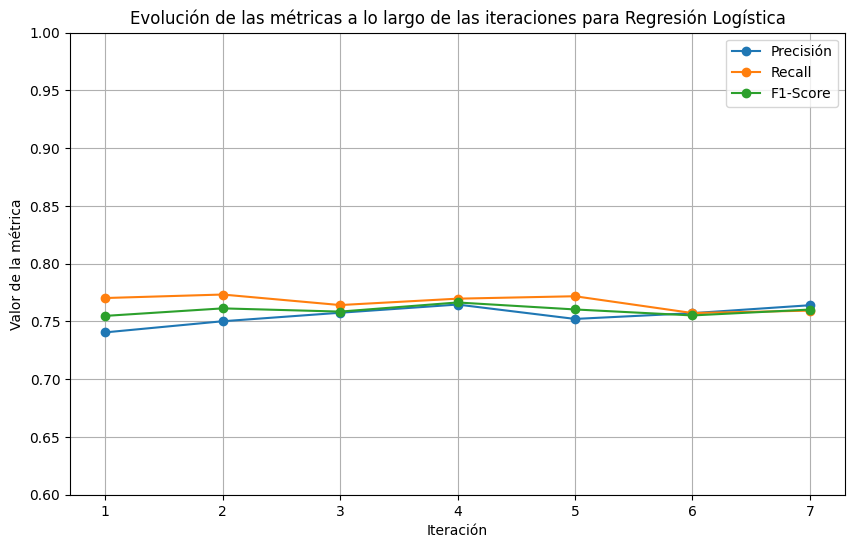

In [12]:
# Graficar la evolución de las métricas
plt.figure(figsize=(10, 6))

# Graficar precisión
plt.plot(iterations, precision_list, label='Precisión', marker='o')
# Graficar recall
plt.plot(iterations, recall_list, label='Recall', marker='o')
# Graficar F1-Score
plt.plot(iterations, f1_list, label='F1-Score', marker='o')

# Etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Valor de la métrica')
plt.title('Evolución de las métricas a lo largo de las iteraciones para Regresión Logística')
plt.ylim(0.6, 1)
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [9]:
# Distribución final de géneros
print("Distribución final de géneros etiquetados:")
print(labeled_data['gender'].value_counts())

Distribución final de géneros etiquetados:
gender
Man      893
Woman    482
Name: count, dtype: int64


In [17]:
labeled_data = df[df['gender'].isin(['Woman', 'Man'])]
unlabeled_data = df[df['gender'] == 'NotSpecified']

labeled_data.loc[:, 'bio'] = labeled_data['bio'].apply(apply_stemming)
labeled_data.loc[:, 'interest'] = labeled_data['interest'].apply(apply_stemming)
unlabeled_data.loc[:, 'bio'] = unlabeled_data['bio'].apply(apply_stemming)
unlabeled_data.loc[:, 'interest'] = unlabeled_data['interest'].apply(apply_stemming)

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
labeled_vectors = vectorizer.fit_transform(labeled_data['bio'] + ' ' + labeled_data['interest_text'])
unlabeled_vectors = vectorizer.transform(unlabeled_data['bio'] + ' ' + unlabeled_data['interest_text'])

y_labeled = labeled_data['gender']

# Inicializar el modelo
model =  RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the model with the initially labeled data
model.fit(labeled_vectors, y_labeled)


# Configuración para realizar cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo utilizando cross-validation en los datos etiquetados
cv_results = cross_validate(model, labeled_vectors, y_labeled, cv=cv, scoring={'precision': precision, 'recall': recall, 'f1': f1})

# Mostrar los resultados
print("Resultados de la validación cruzada:")

print(f"Precisión (precision): {cv_results['test_precision']}")
print(f"Recall: {cv_results['test_recall']}")
print(f"F1-Score: {cv_results['test_f1']}")

print(f"Precisión promedio: {cv_results['test_precision'].mean():.4f}")
print(f"Recall promedio: {cv_results['test_recall'].mean():.4f}")
print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")
print(f"Desviación estándar de precisión: {cv_results['test_precision'].std():.4f}")
print(f"Desviación estándar de recall: {cv_results['test_recall'].std():.4f}")
print(f"Desviación estándar de F1-Score: {cv_results['test_f1'].std():.4f}")

# Listas para almacenar los resultados de cada iteración
precision_list = []
recall_list = []
f1_list = []
iterations = []

target_labeled_size = len(df) / 2
confidence_threshold = 0.90 # Umbral de confianza
iteration = 0

while len(labeled_data) < target_labeled_size:
    print(f"\nIteración {iteration + 1}")

    # Predecir probabilidades para los datos no etiquetados
    probs = model.predict_proba(unlabeled_vectors)
    predicted_labels = model.predict(unlabeled_vectors)

    # Seleccionar predicciones con alta confianza
    confident_indices = np.max(probs, axis=1) >= confidence_threshold
    confident_unlabeled_data = unlabeled_data[confident_indices]
    
    if confident_unlabeled_data.empty:
        print("No se encontraron predicciones confiables. Deteniendo iteraciones.")
        break

    # Añadir datos confiables al conjunto de entrenamiento
    confident_vectors = unlabeled_vectors[confident_indices]
    confident_labels = predicted_labels[confident_indices]

    # Expandir el conjunto de datos etiquetados
    if iteration == 0:
        labeled_vectors = np.vstack([labeled_vectors.toarray(), confident_vectors.toarray()])
        y_labeled= np.concatenate([y_labeled, confident_labels])
    else:
        labeled_vectors = np.vstack([labeled_vectors, confident_vectors.toarray()])
        y_labeled= np.concatenate([y_labeled, confident_labels])

    # Actualizar los datos etiquetados y no etiquetados
    labeled_data = pd.concat([labeled_data, confident_unlabeled_data.assign(gender=confident_labels)])
    unlabeled_vectors = unlabeled_vectors[~confident_indices]
    unlabeled_data = unlabeled_data[~confident_indices]

    # Reentrenar el modelo con el conjunto ampliado
    model.fit(labeled_vectors, y_labeled)
    
    iteration += 1

    # Evaluar el modelo utilizando cross-validation después de la iteración
    cv_results = cross_validate(model, labeled_vectors, y_labeled, cv=cv, scoring={'precision': precision, 'recall': recall, 'f1': f1})

    # Almacenar los resultados de las métricas
    precision_list.append(cv_results['test_precision'].mean())
    recall_list.append(cv_results['test_recall'].mean())
    f1_list.append(cv_results['test_f1'].mean())
    iterations.append(iteration)

    # Mostrar los resultados
    print("Resultados de la validación cruzada:")

    print(f"Precisión (precision): {cv_results['test_precision']}")
    print(f"Recall: {cv_results['test_recall']}")
    print(f"F1-Score: {cv_results['test_f1']}")

    print(f"Precisión promedio: {cv_results['test_precision'].mean():.4f}")
    print(f"Recall promedio: {cv_results['test_recall'].mean():.4f}")
    print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")
    print(f"Desviación estándar de precisión: {cv_results['test_precision'].std():.4f}")
    print(f"Desviación estándar de recall: {cv_results['test_recall'].std():.4f}")
    print(f"Desviación estándar de F1-Score: {cv_results['test_f1'].std():.4f}")

    # Verificar si hemos alcanzado la mitad del dataset etiquetado
    if len(labeled_data) >= target_labeled_size:
        print("Se ha alcanzado la mitad del dataset etiquetado.")
        break

Resultados de la validación cruzada:
Precisión (precision): [0.71287129 0.68041237 0.71111111 0.72641509 0.71717172]
Recall: [0.80898876 0.74157303 0.71910112 0.86516854 0.79775281]
F1-Score: [0.75789474 0.70967742 0.7150838  0.78974359 0.75531915]
Precisión promedio: 0.7096
Recall promedio: 0.7865
F1-Score promedio: 0.7455
Desviación estándar de precisión: 0.0155
Desviación estándar de recall: 0.0517
Desviación estándar de F1-Score: 0.0297

Iteración 1
Resultados de la validación cruzada:
Precisión (precision): [0.84158416 0.73333333 0.74561404 0.74509804 0.76576577]
Recall: [0.81730769 0.85436893 0.82524272 0.73786408 0.82524272]
F1-Score: [0.82926829 0.78923767 0.78341014 0.74146341 0.79439252]
Precisión promedio: 0.7663
Recall promedio: 0.8120
F1-Score promedio: 0.7876
Desviación estándar de precisión: 0.0391
Desviación estándar de recall: 0.0392
Desviación estándar de F1-Score: 0.0280

Iteración 2
Resultados de la validación cruzada:
Precisión (precision): [0.8        0.78512397 0

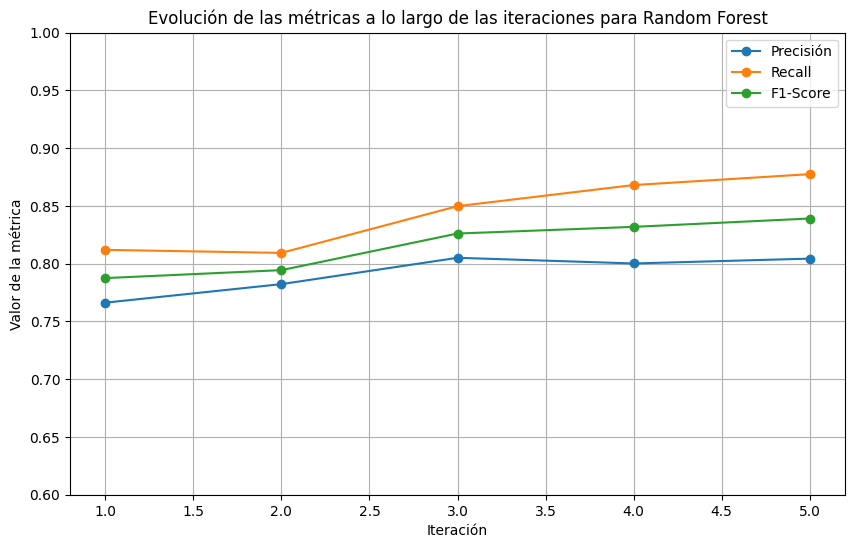

In [18]:
# Graficar la evolución de las métricas
plt.figure(figsize=(10, 6))

# Graficar precisión
plt.plot(iterations, precision_list, label='Precisión', marker='o')
# Graficar recall
plt.plot(iterations, recall_list, label='Recall', marker='o')
# Graficar F1-Score
plt.plot(iterations, f1_list, label='F1-Score', marker='o')

# Etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Valor de la métrica')
plt.title('Evolución de las métricas a lo largo de las iteraciones para Random Forest')
plt.ylim(0.6, 1)
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [15]:
# Distribución final de géneros
print("Distribución final de géneros etiquetados:")
print(labeled_data['gender'].value_counts())

Distribución final de géneros etiquetados:
gender
Man      1299
Woman     702
Name: count, dtype: int64


Distribución final de géneros etiquetados:
gender
Man      1299
Woman     702
Name: count, dtype: int64


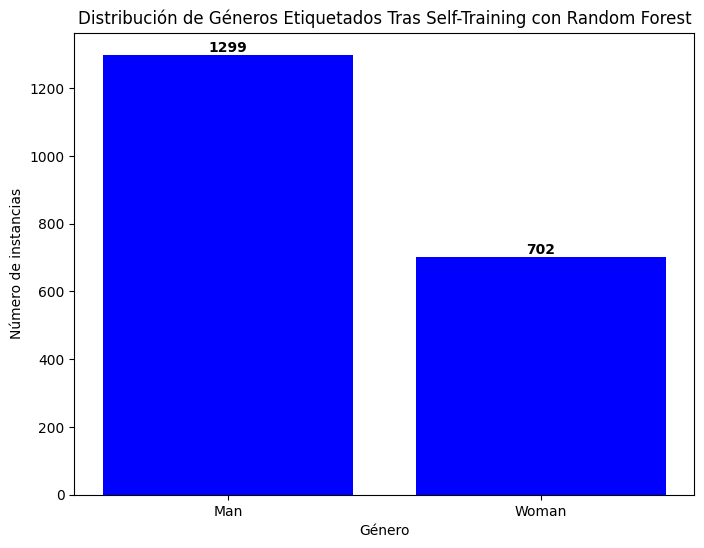

In [25]:
# Obtener la distribución final de géneros etiquetados
gender_distribution = labeled_data['gender'].value_counts()

# Imprimir la distribución
print("Distribución final de géneros etiquetados:")
print(gender_distribution)

# Graficar la distribución con matplotlib
plt.figure(figsize=(8, 6))

# Crear el gráfico de barras
bars = plt.bar(gender_distribution.index, gender_distribution.values, color='blue')

# Añadir los valores encima de cada barra
for bar in bars:
    yval = bar.get_height()  # Obtener la altura de cada barra (el valor de la barra)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1,  # Coloca el texto encima de la barra
             str(int(yval)), ha='center', va='bottom', fontweight='bold')  # 'ha' es el alineamiento horizontal, 'va' es el vertical

# Etiquetas y título
plt.xlabel('Género')
plt.ylabel('Número de instancias')
plt.title('Distribución de Géneros Etiquetados Tras Self-Training con Random Forest')

# Mostrar la gráfica
plt.show()

In [20]:
labeled_data

,age,bio,job,school,anthem_title,anthem_artist,gender,descriptor_text,interest_text,total_photos,desition,longitud,latitud,hash_key,descriptor,interest,city_hashed
7,18.0,anatomicalheart venezuela,['NotSpecified'],NaN,NaN,NaN,Woman,|Virgo|Gym rat,festivals instagram travel world traveler sho...,5,2,-3.684574,40.415211,4.220185e+18,"['Virgo', 'Gym rat']","[ 'festiv ' , 'instagram ' , 'travel ' , 'worl...",500a2b51765bf57441a2a5ba95621dcccc92722c51d321...
10,25.0,i dont know what i want or what im look for ha...,['NotSpecified'],NaN,NaN,NaN,Woman,|Better in person|Occasionally|Non-smoker|Dog,walking travel movies music outdoors,8,2,-3.684574,40.415211,3.602085e+18,"['Better in person', 'Occasionally', 'Non-smok...","[ 'walk ' , 'travel ' , 'movi ' , 'music ' , '...",4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
12,20.0,to the insta better sparklingheart,['NotSpecified'],Grado Medio Estetica Y Belleza,MIDDLE OF THE NHT,Elley Duhé,Woman,|Virgo|B time texter|Non-smoker|All the drinks...,fashion grab a drink instagram photography pa...,11,2,-3.684574,40.415211,4.553127e+18,"['Virgo', 'B time texter', 'Non-smoker', 'All ...","[ 'fashion ' , 'grab a drink ' , 'instagram ' ...",4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
13,19.0,libra womanfairylightskintoneperformingartsdiz...,['NotSpecified'],NaN,jawbreaker,Machine Gun Kelly,Woman,|Libra|Better in person,museum photography language exchange coffee s...,13,2,-3.684574,40.415211,-5.379741e+18,"['Libra', 'Better in person']","[ 'museum ' , 'photographi ' , 'languag exchan...",500a2b51765bf57441a2a5ba95621dcccc92722c51d321...
22,20.0,if you are the one in the last photo go ahead ...,['NotSpecified'],NaN,Kiss Me More (feat. SZA),Doja Cat; SZA,Woman,|Cat|Virgo,coffee gamer cat lover,12,2,-3.684574,40.415211,4.418117e+18,"['Cat', 'Virgo']","[ 'coffe ' , 'gamer ' , 'cat lover ' ]",8206299e7d15db1d75e8c44c5f48523d4f88f0513b6adc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3918,19.0,gin tonictravelsportsclubbingcar,['NotSpecified'],NaN,NaN,NaN,Man,NaN,nan,6,2,2.188010,41.388597,-5.883515e+18,[],[ ],4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
3920,26.0,gin toniccoffeemusicnetflixwalk,['NotSpecified'],NaN,NaN,NaN,Man,NaN,nan,5,2,2.188010,41.388597,-6.932823e+18,[],[ ],4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
3922,28.0,cypru just move to barcelona for a while,['NotSpecified'],NaN,NaN,NaN,Man,|WehtliftingGymEntrepreneurshipCookingClubbing,nan,8,2,2.188010,41.388597,7.264514e+18,['WehtliftingGymEntrepreneurshipCookingClubbing'],[ ],4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...
3930,26.0,ohayoo~ i would like to find someon with whom ...,['NotSpecified'],NaN,NaN,NaN,Man,|Non-smoker Cancer Cat Better in person Cockta...,nan,5,2,2.188010,41.388597,7.383760e+18,['Non-smoker Cancer Cat Better in person Cockt...,[ ],4f53cda18c2baa0c0354bb5f9a3ecbe5ed12ab4d8e11ba...


In [165]:
# Distribución final de géneros
print("Distribución final de géneros etiquetados:")
print(labeled_data['gender'].value_counts())

Distribución final de géneros etiquetados:
gender
Man      1060
Woman     671
Name: count, dtype: int64


In [26]:
labeled_data = df[df['gender'].isin(['Woman', 'Man'])]
unlabeled_data = df[df['gender'] == 'NotSpecified']

labeled_data.loc[:, 'bio'] = labeled_data['bio'].apply(apply_stemming)
labeled_data.loc[:, 'interest'] = labeled_data['interest'].apply(apply_stemming)
unlabeled_data.loc[:, 'bio'] = unlabeled_data['bio'].apply(apply_stemming)
unlabeled_data.loc[:, 'interest'] = unlabeled_data['interest'].apply(apply_stemming)

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
labeled_vectors = vectorizer.fit_transform(labeled_data['bio'] + ' ' + labeled_data['interest_text'])
unlabeled_vectors = vectorizer.transform(unlabeled_data['bio'] + ' ' + unlabeled_data['interest_text'])

y_labeled = labeled_data['gender']

# Inicializar el modelo
model =  MultinomialNB()

# Fit the model with the initially labeled data
model.fit(labeled_vectors, y_labeled)


# Configuración para realizar cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo utilizando cross-validation en los datos etiquetados
cv_results = cross_validate(model, labeled_vectors, y_labeled, cv=cv, scoring={'precision': precision, 'recall': recall, 'f1': f1})

# Mostrar los resultados
print("Resultados de la validación cruzada:")

print(f"Precisión (precision): {cv_results['test_precision']}")
print(f"Recall: {cv_results['test_recall']}")
print(f"F1-Score: {cv_results['test_f1']}")

print(f"Precisión promedio: {cv_results['test_precision'].mean():.4f}")
print(f"Recall promedio: {cv_results['test_recall'].mean():.4f}")
print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")
print(f"Desviación estándar de precisión: {cv_results['test_precision'].std():.4f}")
print(f"Desviación estándar de recall: {cv_results['test_recall'].std():.4f}")
print(f"Desviación estándar de F1-Score: {cv_results['test_f1'].std():.4f}")

# Listas para almacenar los resultados de cada iteración
precision_list = []
recall_list = []
f1_list = []
iterations = []

target_labeled_size = len(df) / 2
confidence_threshold = 0.90 # Umbral de confianza
iteration = 0

while len(labeled_data) < target_labeled_size:
    print(f"\nIteración {iteration + 1}")

    # Predecir probabilidades para los datos no etiquetados
    probs = model.predict_proba(unlabeled_vectors)
    predicted_labels = model.predict(unlabeled_vectors)

    # Seleccionar predicciones con alta confianza
    confident_indices = np.max(probs, axis=1) >= confidence_threshold
    confident_unlabeled_data = unlabeled_data[confident_indices]
    
    if confident_unlabeled_data.empty:
        print("No se encontraron predicciones confiables. Deteniendo iteraciones.")
        break

    # Añadir datos confiables al conjunto de entrenamiento
    confident_vectors = unlabeled_vectors[confident_indices]
    confident_labels = predicted_labels[confident_indices]

    # Expandir el conjunto de datos etiquetados
    if iteration == 0:
        labeled_vectors = np.vstack([labeled_vectors.toarray(), confident_vectors.toarray()])
        y_labeled= np.concatenate([y_labeled, confident_labels])
    else:
        labeled_vectors = np.vstack([labeled_vectors, confident_vectors.toarray()])
        y_labeled= np.concatenate([y_labeled, confident_labels])

    # Actualizar los datos etiquetados y no etiquetados
    labeled_data = pd.concat([labeled_data, confident_unlabeled_data.assign(gender=confident_labels)])
    unlabeled_vectors = unlabeled_vectors[~confident_indices]
    unlabeled_data = unlabeled_data[~confident_indices]

    # Reentrenar el modelo con el conjunto ampliado
    model.fit(labeled_vectors, y_labeled)
    
    iteration += 1

    # Evaluar el modelo utilizando cross-validation después de la iteración
    cv_results = cross_validate(model, labeled_vectors, y_labeled, cv=cv, scoring={'precision': precision, 'recall': recall, 'f1': f1})

    # Almacenar los resultados de las métricas
    precision_list.append(cv_results['test_precision'].mean())
    recall_list.append(cv_results['test_recall'].mean())
    f1_list.append(cv_results['test_f1'].mean())
    iterations.append(iteration)


    # Mostrar los resultados
    print("Resultados de la validación cruzada:")

    print(f"Precisión (precision): {cv_results['test_precision']}")
    print(f"Recall: {cv_results['test_recall']}")
    print(f"F1-Score: {cv_results['test_f1']}")

    print(f"Precisión promedio: {cv_results['test_precision'].mean():.4f}")
    print(f"Recall promedio: {cv_results['test_recall'].mean():.4f}")
    print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")
    print(f"Desviación estándar de precisión: {cv_results['test_precision'].std():.4f}")
    print(f"Desviación estándar de recall: {cv_results['test_recall'].std():.4f}")
    print(f"Desviación estándar de F1-Score: {cv_results['test_f1'].std():.4f}")

    # Verificar si hemos alcanzado la mitad del dataset etiquetado
    if len(labeled_data) >= target_labeled_size:
        print("Se ha alcanzado la mitad del dataset etiquetado.")
        break

Resultados de la validación cruzada:
Precisión (precision): [0.74226804 0.75531915 0.72222222 0.73684211 0.70833333]
Recall: [0.80898876 0.79775281 0.73033708 0.78651685 0.76404494]
F1-Score: [0.77419355 0.77595628 0.72625698 0.76086957 0.73513514]
Precisión promedio: 0.7330
Recall promedio: 0.7775
F1-Score promedio: 0.7545
Desviación estándar de precisión: 0.0163
Desviación estándar de recall: 0.0279
Desviación estándar de F1-Score: 0.0203

Iteración 1
Resultados de la validación cruzada:
Precisión (precision): [0.72916667 0.74       0.78431373 0.73786408 0.71171171]
Recall: [0.74468085 0.78723404 0.85106383 0.8172043  0.84946237]
F1-Score: [0.73684211 0.7628866  0.81632653 0.7755102  0.7745098 ]
Precisión promedio: 0.7406
Recall promedio: 0.8099
F1-Score promedio: 0.7732
Desviación estándar de precisión: 0.0240
Desviación estándar de recall: 0.0402
Desviación estándar de F1-Score: 0.0257

Iteración 2
Resultados de la validación cruzada:
Precisión (precision): [0.72727273 0.73584906 0

In [13]:
# Distribución final de géneros
print("Distribución final de géneros etiquetados:")
print(labeled_data['gender'].value_counts())

Distribución final de géneros etiquetados:
gender
Woman    1631
Man       442
Name: count, dtype: int64


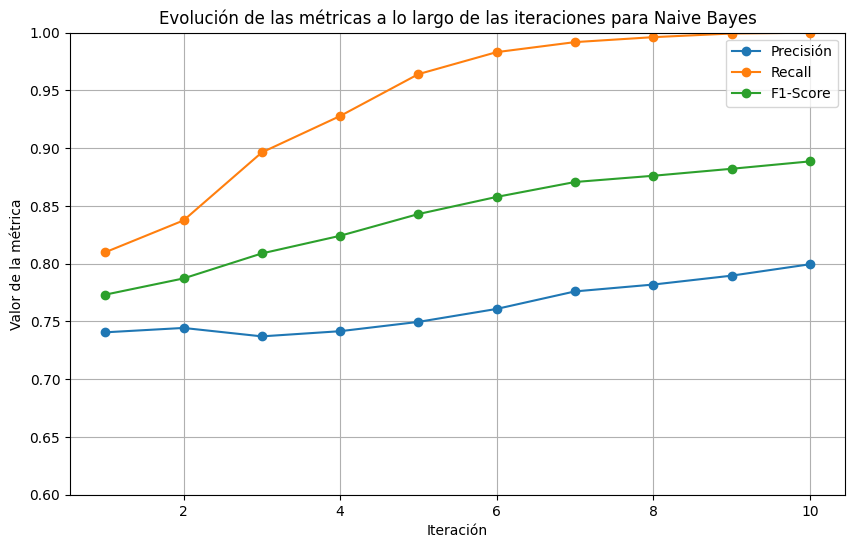

In [27]:
# Graficar la evolución de las métricas
plt.figure(figsize=(10, 6))

# Graficar precisión
plt.plot(iterations, precision_list, label='Precisión', marker='o')
# Graficar recall
plt.plot(iterations, recall_list, label='Recall', marker='o')
# Graficar F1-Score
plt.plot(iterations, f1_list, label='F1-Score', marker='o')

# Etiquetas y título
plt.xlabel('Iteración')
plt.ylabel('Valor de la métrica')
plt.title('Evolución de las métricas a lo largo de las iteraciones para Naive Bayes')
plt.ylim(0.6, 1)
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [23]:
final_dataset = pd.concat([labeled_data, unlabeled_data])
#final_dataset.to_csv('./datasets/dataset_more_labeled.csv', index = False)